# K-means and PCA for handwritten digits clustering

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

## Importing the dataset

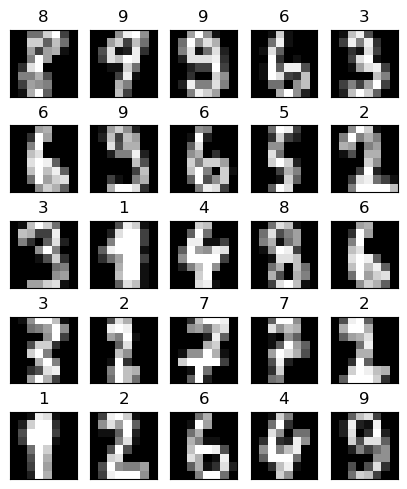

In [2]:
digits = load_digits()
fig, axs = plt.subplots(5, 5, figsize=(5,6))
idxs = np.random.choice(digits.data.shape[0], 25)

for i, idx in enumerate(idxs):
    ax = axs[i//5,i%5]
    ax.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    ax.imshow(digits.images[idx], cmap="gray")
    ax.set_title(digits.target[idx])
    
plt.show()

## Partitioning the dataset

In [3]:
train_data, test_data, train_target, test_target = train_test_split(digits.data, digits.target, test_size=0.1,
                                                    random_state=0, stratify=digits.target)

## Applying PCA for dimensionality reduction

### Centering the dataset

In [4]:
ctd_data = train_data - train_data.mean(axis=0).reshape(1,-1)

### Applying SVD on the dataset matrix

In [5]:
u, s, vh = np.linalg.svd(ctd_data)
n_components = 30
v_reduced = vh.T[:,:n_components]

In [6]:
l = s**2 / ctd_data.shape[0]
print(f"Amount of variance captured: {round(sum(l[:n_components])/sum(l)*100)}%")

Amount of variance captured: 96%


In [7]:
low_dimensional_data = ctd_data @ v_reduced

## Applying K-means on the low dimensional data

### Naive k-means implementation

In [8]:
class KMeans:
    
    def __init__(self, n_clusters):
        self.n_clusters = n_clusters
        self.n_samples = None
        self.n_features = None
        self.centroids = None
        self.labels = None
        
    def _initialize_centroids(self):
        idxs = np.random.choice(self.n_samples, self.n_clusters, replace=False)
        self.centroids = self.X[idxs]
        
    def _get_labels(self):
        P = self.X[:, np.newaxis, :]  # Nx1xD
        diff_sq = (P - self.centroids)**2  # Nx1xD - KxD -> NxKxD # broadcasting
        self.labels = diff_sq.sum(axis=2).argmin(axis=1) 
        
    def _update(self):
        # select the points to the k center and remove N dimension with mean over axis 0
        labels_row = self.labels.reshape((1, -1)) #1xN
        clusters_col = np.arange(self.n_clusters).reshape(-1, 1) #Kx1

        #M[i][j] = 1 if X[j,:] belongs to cluster i else 0 
        M = clusters_col == labels_row  #KxN

        #cluster_sum[i,:] contains the sum of all vectors in cluster i
        cluster_sum = M @ self.X #KxN @ NxD -> KxD 

        #counts[i,:] contains the number of vectors in cluster i
        counts = np.sum(M, axis=1).reshape(-1, 1) #Kx1

        self.centroids = cluster_sum / counts #KxD
             
    def fit(self, X):
        self.X = X
        self.n_samples, self.n_features = X.shape
        
        #initialization
        self._initialize_centroids()
        
        while True:
            #Assignement
            self._get_labels()

            #Update
            old_centroids = self.centroids
            self._update()
            
            if np.allclose(old_centroids, self.centroids):
                break
                
    def predict(self, X):
        P = X[:, np.newaxis, :]  # Nx1xD
        diff_sq = (P - self.centroids)**2  # Nx1xD - KxD -> NxKxD # broadcasting
        labels = diff_sq.sum(axis=2).argmin(axis=1) 
        return labels

## Prediction of the model on the train data

In [9]:
kmeans = KMeans(10)
kmeans.fit(low_dimensional_data)

### Getting the mapping array from cluster index to number

In [10]:
def get_cluster_to_number_mapping(i, target, labels):
    cluster_labels = target[labels == i]
    values, counts = np.unique(cluster_labels, return_counts=True)
    return values[counts.argmax()]

label_to_number = np.array([get_cluster_to_number_mapping(i, train_target, kmeans.labels) for i in range(kmeans.n_clusters)])

In [11]:
prediction = np.take(label_to_number, kmeans.labels)

In [12]:
print(f"Accuracy: {sum(train_target == prediction) / train_target.shape[0]}")

Accuracy: 0.8144712430426716


### Visualization

In [13]:
v_to_2d = vh.T[:,:2]
data_2d = ctd_data @ v_to_2d

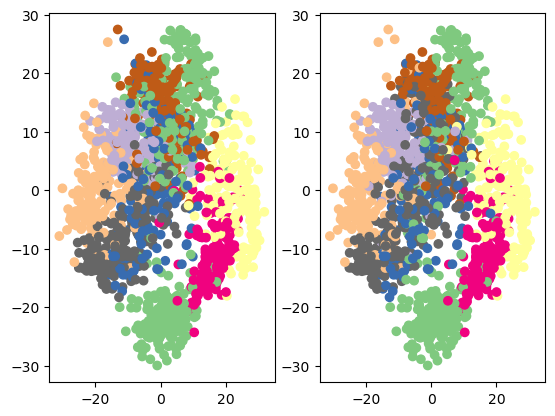

In [14]:
fig, axs = plt.subplots(1, 2)

axs[0].scatter(*data_2d.T, c=prediction, cmap="Accent")
axs[1].scatter(*data_2d.T, c=train_target, cmap="Accent")
plt.show()

## Prediction of the model on the test data

### Applying PCA

In [15]:
ctd_data = test_data - test_data.mean(axis=0).reshape(1,-1)

In [16]:
low_dimensional_data = ctd_data @ v_reduced

### Giving in input the reduced data to the model

In [17]:
prediction = np.take(label_to_number, kmeans.predict(low_dimensional_data))

In [18]:
print(f"Accuracy: {sum(test_target == prediction) / test_target.shape[0]}")

Accuracy: 0.8055555555555556


### Visualization

In [19]:
v_to_2d = vh.T[:,:2]
data_2d = ctd_data @ v_to_2d

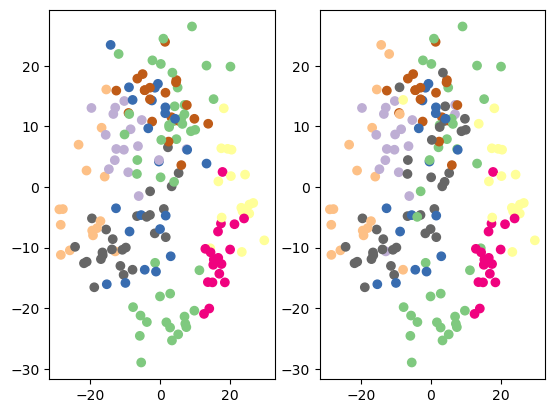

In [20]:
fig, axs = plt.subplots(1, 2)

axs[0].scatter(*data_2d.T, c=prediction, cmap="Accent")
axs[1].scatter(*data_2d.T, c=test_target, cmap="Accent")
plt.show()

# The same procedure using scikit-learn

In [21]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

## Applying PCA for dimensionality reduction

In [22]:
pca = PCA(n_components = 30)

In [23]:
low_dimensional_data = pca.fit_transform(train_data)

In [24]:
print(f"Amount of variance captured: {round(sum(pca.explained_variance_ratio_*100))}%")

Amount of variance captured: 96%


## Applying K-means on the low dimensional data

In [25]:
kmeans = KMeans(n_clusters=10).fit(low_dimensional_data)

In [26]:
label_to_number = np.array([get_cluster_to_number_mapping(i, train_target, kmeans.labels_) for i in range(kmeans.n_clusters)])

## Prediction of the model on the train data

In [27]:
prediction = np.take(label_to_number, kmeans.labels_)

In [28]:
print(f"Accuracy: {sum(train_target == prediction) / train_target.shape[0]}")

Accuracy: 0.7909709338280767


### Visualization

In [29]:
pca_2d = PCA(n_components = 2)
data_2d = pca_2d.fit_transform(train_data)

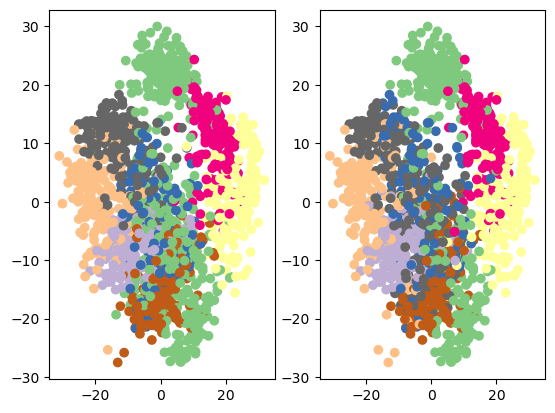

In [30]:
fig, axs = plt.subplots(1, 2)

axs[0].scatter(*data_2d.T, c=prediction, cmap="Accent")
axs[1].scatter(*data_2d.T, c=train_target, cmap="Accent")
plt.show()

## Prediction of the model on the test data

In [31]:
low_dimensional_data = pca.transform(test_data)

In [32]:
prediction = np.take(label_to_number, kmeans.predict(low_dimensional_data))

In [33]:
print(f"Accuracy: {sum(test_target == prediction) / test_target.shape[0]}")

Accuracy: 0.7888888888888889


### Visualization

In [34]:
data_2d = pca_2d.transform(test_data)

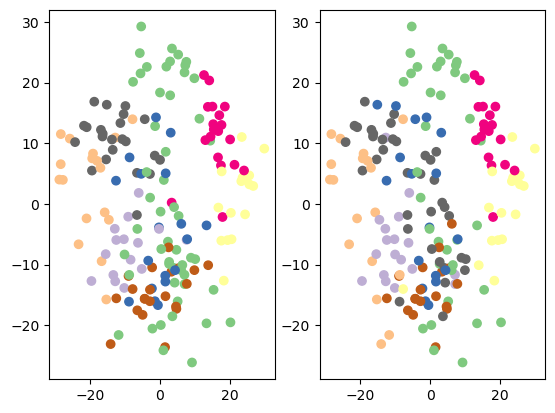

In [35]:
fig, axs = plt.subplots(1, 2)

axs[0].scatter(*data_2d.T, c=prediction, cmap="Accent")
axs[1].scatter(*data_2d.T, c=test_target, cmap="Accent")
plt.show()